# Load Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
import optuna

# Import ML models
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

# Load file

In [2]:
train = pd.read_csv("/kaggle/input/playground-series-s4e10/train.csv")
test = pd.read_csv("/kaggle/input/playground-series-s4e10/test.csv")
submission = pd.read_csv("/kaggle/input/playground-series-s4e10/sample_submission.csv")

In [3]:
train.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


In [4]:
test.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,58645,23,69000,RENT,3.0,HOMEIMPROVEMENT,F,25000,15.76,0.36,N,2
1,58646,26,96000,MORTGAGE,6.0,PERSONAL,C,10000,12.68,0.10,Y,4
2,58647,26,30000,RENT,5.0,VENTURE,E,4000,17.19,0.13,Y,2
3,58648,33,50000,RENT,4.0,DEBTCONSOLIDATION,A,7000,8.90,0.14,N,7
4,58649,26,102000,MORTGAGE,8.0,HOMEIMPROVEMENT,D,15000,16.32,0.15,Y,4


In [5]:
submission.head()

,id,loan_status
0,58645,0.5
1,58646,0.5
2,58647,0.5
3,58648,0.5
4,58649,0.5


# Define feature and target columns

In [6]:
# Define feature columns and target
X = train.drop(columns=['id', 'loan_status'])
y = train['loan_status']
X_test = test.drop(columns=['id'])

# Train test split

In [7]:
# Split data for validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Feature Engineering

In [8]:
# Custom function to create new features
def feature_engineering(df):
    # Log transformation
    df['log_person_income'] = np.log1p(df['person_income'])
    df['log_loan_amnt'] = np.log1p(df['loan_amnt'])
    
    # Debt-to-Income ratio
    df['dti_ratio'] = df['loan_amnt'] / df['person_income']
    
    # Employment categories
    df['employment_category'] = pd.cut(df['person_emp_length'], 
                                        bins=[-1, 2, 5, 10, 20], 
                                        labels=['Short-term', 'Medium-term', 'Long-term', 'Very long-term'])
    
    # Credit history and default indicator
    df['short_credit_history'] = (df['cb_person_cred_hist_length'] < 5).astype(int)
    df['default_history'] = (df['cb_person_default_on_file'] == 'Y').astype(int)
    
    # Risk indicators
    df['high_interest'] = (df['loan_int_rate'] > 12).astype(int)
    df['high_loan_percent_income'] = (df['loan_percent_income'] > 0.3).astype(int)
    
    return df

In [9]:
# Define custom transformer for feature engineering
feature_engineer = FunctionTransformer(feature_engineering)

In [10]:
# Updated numerical and categorical columns
numerical_cols = ['person_age', 'person_income', 'loan_amnt', 'loan_int_rate', 'cb_person_cred_hist_length',
                  'log_person_income', 'log_loan_amnt', 'dti_ratio']
categorical_cols = ['person_home_ownership', 'loan_intent', 'loan_grade', 'employment_category']

# Column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)

# Models and Hyperparameter tuning

In [11]:
# Function to define models and tune hyperparameters using Optuna
def objective(trial):
    # Define hyperparameters for each model
    xgb_params = {
        'n_estimators': trial.suggest_int('xgb_n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('xgb_max_depth', 3, 10),
        'learning_rate': trial.suggest_float('xgb_learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('xgb_subsample', 0.6, 1.0)
    }
    cat_params = {
        'iterations': trial.suggest_int('cat_iterations', 100, 1000),
        'depth': trial.suggest_int('cat_depth', 3, 10),
        'learning_rate': trial.suggest_float('cat_learning_rate', 0.01, 0.3),
        'l2_leaf_reg': trial.suggest_float('cat_l2_leaf_reg', 1.0, 10.0)
    }
    lgb_params = {
        'n_estimators': trial.suggest_int('lgb_n_estimators', 100, 1000),
        'num_leaves': trial.suggest_int('lgb_num_leaves', 31, 128),
        'learning_rate': trial.suggest_float('lgb_learning_rate', 0.01, 0.3),
        'min_child_samples': trial.suggest_int('lgb_min_child_samples', 20, 100)
    }
    
    # Initialize models with hyperparameters
    xgb_model = XGBClassifier(**xgb_params, use_label_encoder=False, eval_metric='logloss', random_state=42)
    cat_model = CatBoostClassifier(**cat_params, verbose=0, random_state=42)
    lgb_model = LGBMClassifier(**lgb_params, verbosity=0 , random_state=42)
    
    # Ensemble using Voting Classifier
    ensemble = VotingClassifier(
        estimators=[
            ('xgb', xgb_model),
            ('cat', cat_model),
            ('lgb', lgb_model)
        ],
        voting='soft'
    )
    
   
    # Final pipeline with feature engineering
    pipeline = Pipeline(steps=[
        ('feature_engineering', feature_engineer),
        ('preprocessor', preprocessor),
        ('classifier', ensemble)  
    ])
    
    # Train the model
    pipeline.fit(X_train, y_train)
    
    # Predict and evaluate AUC-ROC on validation set
    val_preds = pipeline.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, val_preds)
    
    return auc

In [12]:
# Optuna for hyperparameter tuning
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)  # Increase trials for better results

[I 2024-10-24 13:43:57,768] A new study created in memory with name: no-name-86cdede0-5153-4f25-a9c2-992c83e84403
[I 2024-10-24 13:44:15,753] Trial 0 finished with value: 0.9565328037631864 and parameters: {'xgb_n_estimators': 930, 'xgb_max_depth': 3, 'xgb_learning_rate': 0.22079643215483066, 'xgb_subsample': 0.9384544770369573, 'cat_iterations': 125, 'cat_depth': 6, 'cat_learning_rate': 0.22004251954418722, 'cat_l2_leaf_reg': 7.099356344732017, 'lgb_n_estimators': 876, 'lgb_num_leaves': 64, 'lgb_learning_rate': 0.0959967429413281, 'lgb_min_child_samples': 50}. Best is trial 0 with value: 0.9565328037631864.
[I 2024-10-24 13:44:36,938] Trial 1 finished with value: 0.9573150745928364 and parameters: {'xgb_n_estimators': 409, 'xgb_max_depth': 8, 'xgb_learning_rate': 0.07341237467372572, 'xgb_subsample': 0.9336036972302098, 'cat_iterations': 901, 'cat_depth': 6, 'cat_learning_rate': 0.2072890421579277, 'cat_l2_leaf_reg': 6.939123468230688, 'lgb_n_estimators': 195, 'lgb_num_leaves': 51, 'l

In [13]:
# Get the best hyperparameters
best_params = study.best_params
print(f"Best AUC-ROC: {study.best_value}")
print(f"Best parameters: {best_params}")

Best AUC-ROC: 0.9592785202038513
Best parameters: {'xgb_n_estimators': 332, 'xgb_max_depth': 4, 'xgb_learning_rate': 0.18295528846297043, 'xgb_subsample': 0.9643055887120003, 'cat_iterations': 710, 'cat_depth': 3, 'cat_learning_rate': 0.25406939449738003, 'cat_l2_leaf_reg': 6.989157636926534, 'lgb_n_estimators': 177, 'lgb_num_leaves': 70, 'lgb_learning_rate': 0.027663772516890388, 'lgb_min_child_samples': 100}


# Train Model with best parameters

In [14]:
# Train final model with best parameters
final_xgb = XGBClassifier(
    n_estimators=best_params['xgb_n_estimators'],
    max_depth=best_params['xgb_max_depth'],
    learning_rate=best_params['xgb_learning_rate'],
    subsample=best_params['xgb_subsample'],
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

final_cat = CatBoostClassifier(
    iterations=best_params['cat_iterations'],
    depth=best_params['cat_depth'],
    learning_rate=best_params['cat_learning_rate'],
    l2_leaf_reg=best_params['cat_l2_leaf_reg'],
    verbose=0,
    random_state=42
)

final_lgb = LGBMClassifier(
    n_estimators=best_params['lgb_n_estimators'],
    num_leaves=best_params['lgb_num_leaves'],
    learning_rate=best_params['lgb_learning_rate'],
    min_child_samples=best_params['lgb_min_child_samples'],
    random_state=42
)

# Ensemble

In [15]:
# Ensemble with best parameters
final_ensemble = VotingClassifier(
    estimators=[
        ('xgb', final_xgb),
        ('cat', final_cat),
        ('lgb', final_lgb)
    ],
    voting='soft'
)

# Final pipeline with feature engineering
final_pipeline = Pipeline(steps=[
    ('feature_engineering', feature_engineer),
    ('preprocessor', preprocessor),
    ('classifier', final_ensemble)
])

In [16]:
# Train on the entire training data
final_pipeline.fit(X, y)

# Predict on the test set
test_preds = final_pipeline.predict_proba(X_test)[:, 1]

[LightGBM] [Info] Number of positive: 8350, number of negative: 50295
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1518
[LightGBM] [Info] Number of data points in the train set: 58645, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.142382 -> initscore=-1.795644
[LightGBM] [Info] Start training from score -1.795644


# Submission

In [17]:
# Prepare submission file
submission['loan_status'] = test_preds

In [18]:
submission.head()

,id,loan_status
0,58645,0.992943
1,58646,0.020130
2,58647,0.591552
3,58648,0.010302
4,58649,0.042347


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


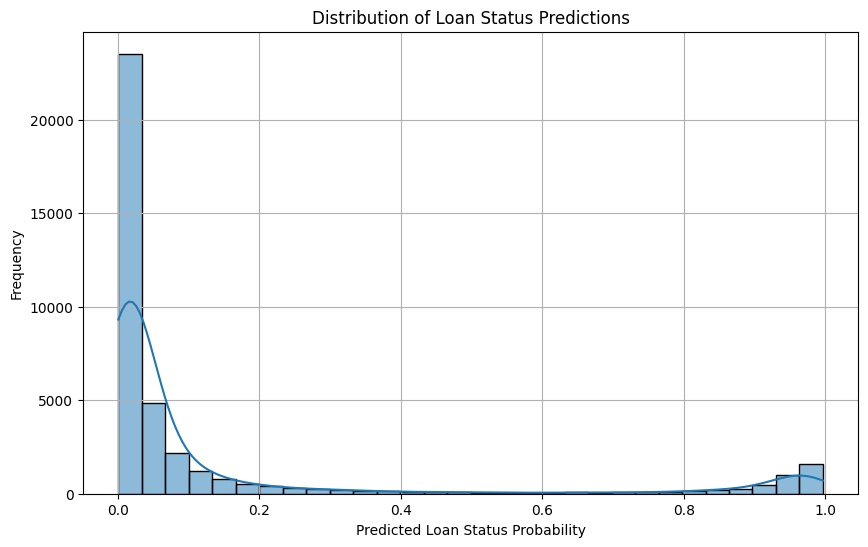

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distribution of the predictions
plt.figure(figsize=(10, 6))
sns.histplot(submission['loan_status'], bins=30, kde=True)
plt.title('Distribution of Loan Status Predictions')
plt.xlabel('Predicted Loan Status Probability')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [20]:
submission.to_csv('submission.csv', index=False)